In [ ]:
# Step 1: Load and preprocess dataset

# Import libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)  # 0 = malignant, 1 = benign

# Check for missing values
print("Missing values in dataset:\n", X.isnull().sum().sum())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Final shapes
print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Target vector shape: {y.shape}")


Missing values in dataset:
 0
Feature matrix shape: (569, 30)
Target vector shape: (569,)


Class distribution (0 = malignant, 1 = benign):
1    357
0    212
Name: count, dtype: int64


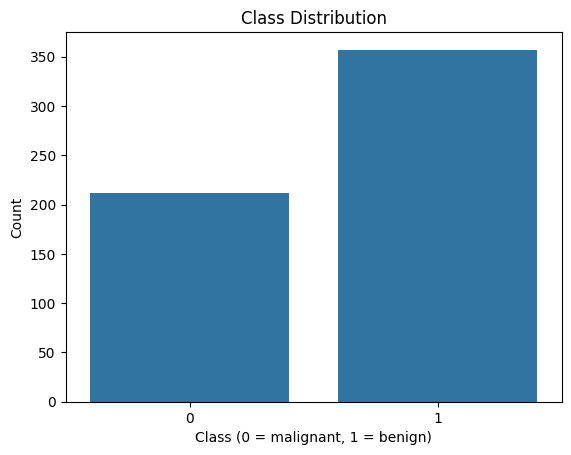

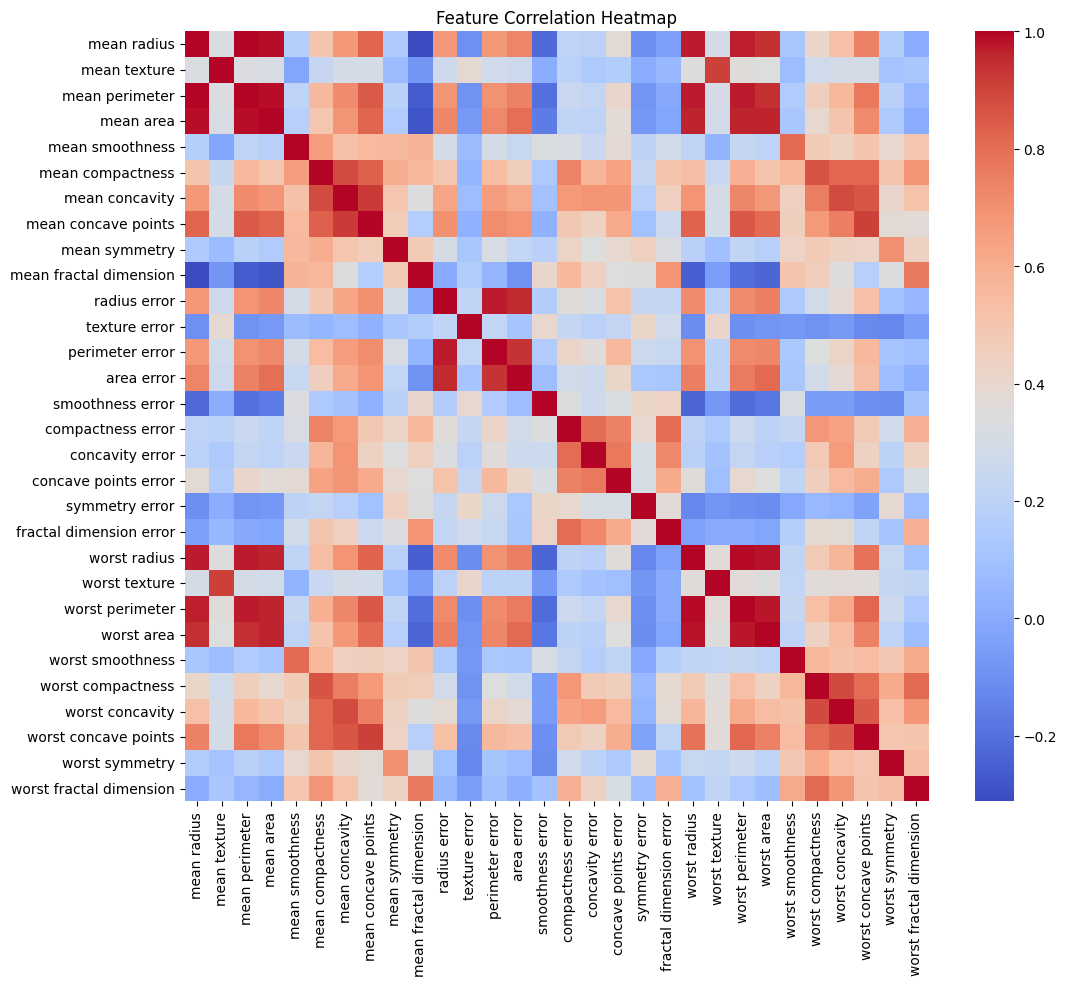

In [ ]:
# Step 2: Perform EDA (class balance, feature correlation)

import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
print("Class distribution (0 = malignant, 1 = benign):")
print(y.value_counts())

# Plot class distribution
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class (0 = malignant, 1 = benign)")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = pd.DataFrame(X_scaled, columns=data.feature_names).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Step 3: Split dataset into training and test sets

from sklearn.model_selection import train_test_split

# Use stratify=y to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (455, 30)
Test set shape: (114, 30)


In [ ]:
# Step 4: Train multiple models

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Define models (default settings for now)
dt_model = DecisionTreeClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier( eval_metric='logloss', random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Stacking: base learners and final estimator
stack_model = StackingClassifier(
    estimators=[
        ('svm', SVC(probability=True)),
        ('nb', GaussianNB()),
        ('dt', DecisionTreeClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit all models
models = {
    "Decision Tree": dt_model,
    "AdaBoost": ada_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Stacking Classifier": stack_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")


Decision Tree trained.
AdaBoost trained.
Gradient Boosting trained.
XGBoost trained.
Random Forest trained.
Stacking Classifier trained.


In [ ]:
# Step 5: Hyperparameter Tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV

# Decision Tree - Hyperparameter Grid
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print("Best Decision Tree Params:")
print(dt_grid.best_params_)

# Random Forest - Hyperparameter Grid
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print("\nBest Random Forest Params:")
print(rf_grid.best_params_)


Best Decision Tree Params:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

Best Random Forest Params:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
# Step 6: Evaluate with 5-Fold Cross-Validation

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Use best tuned models
models['Tuned Decision Tree'] = best_dt
models['Tuned Random Forest'] = best_rf

# Store results
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv = np.mean(cv_scores)

    # Predict on test set
    y_pred = model.predict(X_test)

    # If model supports predict_proba, calculate ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"CV Accuracy: {mean_cv:.4f}")
    print(f"ROC AUC: {auc:.4f}" if auc is not None else "ROC AUC: N/A")

    # Save results
    results[name] = {
        'Accuracy': acc,
        'CV Accuracy': mean_cv,
        'ROC AUC': auc
    }

# Show results in a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Summary:")
print(results_df)



Evaluating Decision Tree...
Accuracy: 0.9123
CV Accuracy: 0.9099
ROC AUC: 0.9157

Evaluating AdaBoost...
Accuracy: 0.9561
CV Accuracy: 0.9692
ROC AUC: 0.9825

Evaluating Gradient Boosting...
Accuracy: 0.9561
CV Accuracy: 0.9560
ROC AUC: 0.9907

Evaluating XGBoost...
Accuracy: 0.9561
CV Accuracy: 0.9626
ROC AUC: 0.9901

Evaluating Random Forest...
Accuracy: 0.9561
CV Accuracy: 0.9538
ROC AUC: 0.9937

Evaluating Stacking Classifier...
Accuracy: 0.9737
CV Accuracy: 0.9648
ROC AUC: 0.9927

Evaluating Tuned Decision Tree...
Accuracy: 0.9211
CV Accuracy: 0.9385
ROC AUC: 0.9163

Evaluating Tuned Random Forest...
Accuracy: 0.9561
CV Accuracy: 0.9670
ROC AUC: 0.9921

Model Evaluation Summary:
                     Accuracy  CV Accuracy   ROC AUC
Decision Tree        0.912281     0.909890  0.915675
AdaBoost             0.956140     0.969231  0.982474
Gradient Boosting    0.956140     0.956044  0.990741
XGBoost              0.956140     0.962637  0.990079
Random Forest        0.956140     0.95384

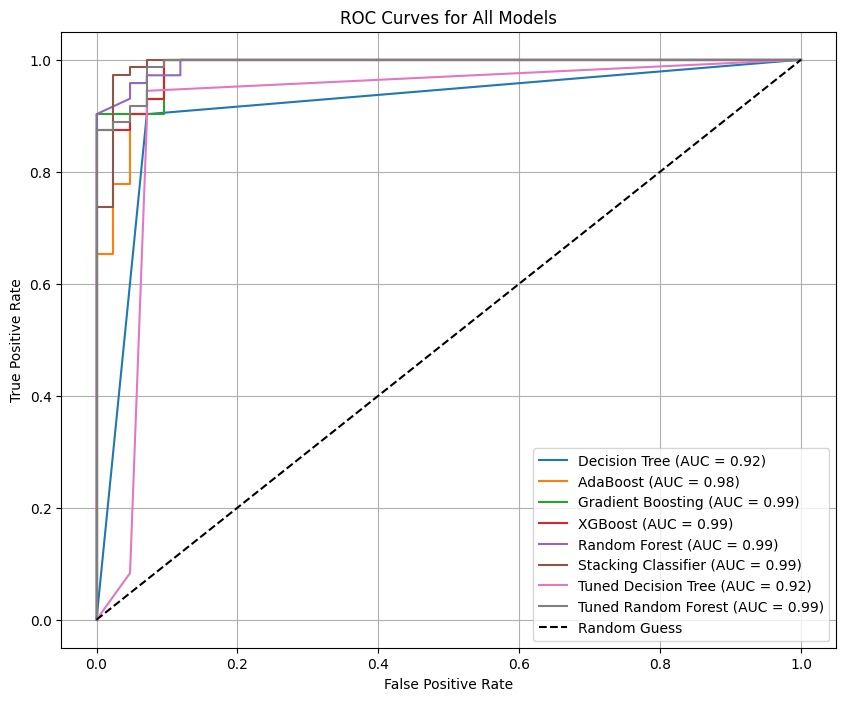

In [ ]:
# Step 7: Plot ROC Curves

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()
